In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms as transforms
import numpy as np
import itertools
import os
import time
import math
import argparse
import losses
import other
from datasets.FairFace import FairFace
from torch.autograd import Variable
from network.teacherNet import Teacher
from network.studentNet import CNN_RIS
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def load_pretrained_model(model, pretrained_dict):
	model_dict = model.state_dict()
	# 1. filter out unnecessary keys
	pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
	# 2. overwrite entries in the existing state dict
	model_dict.update(pretrained_dict) 
	# 3. load the new state dict
	model.load_state_dict(model_dict)

NUM_CLASSES = 7
transform_train = transforms.Compose([
    transforms.RandomCrop(92),
    transforms.RandomHorizontalFlip(),
])
transforms_teacher_Normalize = transforms.Normalize((0.4911152, 0.36028033, 0.30489963), 
                            (0.25160596, 0.21829675, 0.21198231))
transforms_student_Normalize =  transforms.Normalize((0.4911364, 0.3602937, 0.3049148), 
                            (0.24722975, 0.21383813, 0.20771481))
teacher_norm = transforms.Compose([
transforms.ToTensor(),
transforms_teacher_Normalize,
])
student_norm = transforms.Compose([
transforms.Resize(44),
transforms.ToTensor(),
transforms_student_Normalize,
])

trainset = FairFace(split = 'Training', transform=transform_train, student_norm=student_norm, teacher_norm=teacher_norm)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)

net1 = Teacher(num_classes=NUM_CLASSES).cuda()
net2 = Teacher(num_classes=NUM_CLASSES).cuda()
net3 = Teacher(num_classes=NUM_CLASSES).cuda()
net4 = Teacher(num_classes=NUM_CLASSES).cuda()
snet = CNN_RIS(num_classes=NUM_CLASSES).cuda()

tcheckpoint = torch.load('FairFace_MultiTeacher_OurDiversity_0.8_9.0/Best_MultiTeacher_model.t7')
load_pretrained_model(net1, tcheckpoint['Teacher1'])
load_pretrained_model(net2, tcheckpoint['Teacher2'])
load_pretrained_model(net3, tcheckpoint['Teacher3'])
load_pretrained_model(net4, tcheckpoint['Teacher4'])
scheckpoint = torch.load('FairFace_MultiTeacher_OurDiversity_0.8_9.0_KD3/Student_Test_model.t7')
load_pretrained_model(snet, scheckpoint['snet'])

net1.eval()
net2.eval()
net3.eval()
net4.eval()
snet.eval()
for param in net1.parameters():
    param.requires_grad = False
for param in net2.parameters():
    param.requires_grad = False
for param in net3.parameters():
    param.requires_grad = False
for param in net4.parameters():
    param.requires_grad = False
for param in snet.parameters():
    param.requires_grad = False

for batch_idx, (img_teacher, img_student, target) in enumerate(trainloader):
    img_teacher = img_teacher.cuda()
    img_student = img_student.cuda()
    target = target.cuda()
    
    img_teacher, img_student, target = Variable(img_teacher), Variable(img_student), Variable(target)
    with torch.no_grad():
        rb1_t1, rb2_t1, rb3_t1, mimic_t1, out_t1 = net1(img_teacher)
        rb1_t2, rb2_t2, rb3_t2, mimic_t2, out_t2 = net2(img_teacher)
        rb1_t3, rb2_t3, rb3_t3, mimic_t3, out_t3 = net3(img_teacher)
        rb1_t4, rb2_t4, rb3_t4, mimic_t4, out_t4 = net4(img_teacher)
        rb1_s, rb2_s, rb3_s, mimic_s, out_s = snet(img_student)
    break    
mimic = (out_t1+out_t2+out_t3+out_t4)/4
C = torch.cat((out_t1[0][target[0]].unsqueeze(0), out_t2[0][target[0]].unsqueeze(0), \
               out_t3[0][target[0]].unsqueeze(0),out_t4[0][target[0]].unsqueeze(0)),0).unsqueeze(0)

tensor([[-139.7238,  -49.1987,   10.3111,    9.0452]], device='cuda:0')


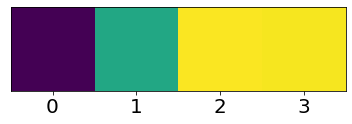

In [3]:
print (C)
plt.figure("C") # 图像窗口名称
plt.imshow(C.cpu(), vmin = -140, vmax = 11)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/C.jpg', dpi=500)
plt.show()

tensor([[-144.9095, -144.2937, -145.9087, -141.0431, -139.7238, -187.5367,
         -144.6806]], device='cuda:0')


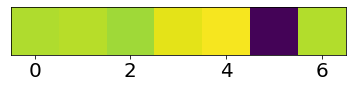

In [5]:
print (out_t1)
plt.figure("out_t1") # 图像窗口名称
plt.imshow(out_t1.cpu(), vmin = -188, vmax = -139)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/out_t1.jpg', dpi=500)
plt.show()

tensor([[ -53.1199, -137.2756,  -54.7831,  -51.3168,  -49.1987,  -55.1040,
          -53.9823]], device='cuda:0')


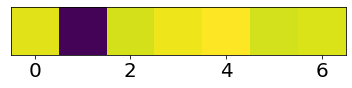

In [7]:
print (out_t2)
plt.figure("out_t2") # 图像窗口名称
plt.imshow(out_t2.cpu(), vmin = -138, vmax = -49)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/out_t2.jpg', dpi=500)
plt.show()

tensor([[-44.8837,   6.4246,   6.2399,  10.2675,  10.3111,   5.9583, -39.0857]],
       device='cuda:0')


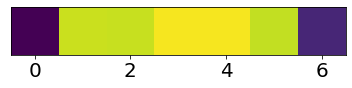

In [9]:
print (out_t3)
plt.figure("out_t3") # 图像窗口名称
plt.imshow(out_t3.cpu(), vmin = -45, vmax = 11)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/out_t3.jpg', dpi=500)
plt.show()

tensor([[  2.7399,   3.4006, -60.7344,   5.4883,   9.0452,   2.3614,   2.9711]],
       device='cuda:0')


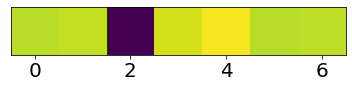

In [11]:
print (out_t4)
plt.figure("out_t4") # 图像窗口名称
plt.imshow(out_t4.cpu(), vmin = -61, vmax = 10)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/out_t4.jpg', dpi=500)
plt.show()

tensor([[-60.0433, -67.9360, -63.7966, -44.1510, -42.3915, -58.5802, -58.6944]],
       device='cuda:0')


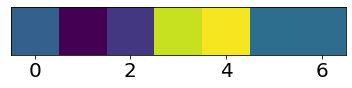

In [13]:
print (mimic)
plt.figure("mimic") # 图像窗口名称
plt.imshow(mimic.cpu(), vmin = -68, vmax = -42)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/mimic.jpg', dpi=500)
plt.show()

tensor([[-15.1866, -14.8564, -23.8354,  -5.9371,  -3.4805, -10.9506, -15.4204]],
       device='cuda:0')


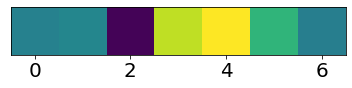

In [15]:
print (out_s)
plt.figure("out_s") # 图像窗口名称
plt.imshow(out_s.cpu(), vmin = -24, vmax = -4)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/out_s.jpg', dpi=500)
plt.show()

In [16]:
min_C = min(C[0])
min_C = -min_C*torch.ones(out_t1.shape).cuda()
Coutputs1 = min_C + out_t1 + 0.00001
Coutputs2 = min_C + out_t2 + 0.00001
Coutputs3 = min_C + out_t3 + 0.00001
Coutputs4 = min_C + out_t4 + 0.00001
Cmimic = min_C + mimic + 0.00001

max_preds = torch.cat((Coutputs1, Coutputs2, Coutputs3,Coutputs4),0)
max_preds = torch.max(max_preds)

weights = torch.cat((Coutputs1[0][target[0]].unsqueeze(0), Coutputs2[0][target[0]].unsqueeze(0), \
                     Coutputs3[0][target[0]].unsqueeze(0), Coutputs4[0][target[0]].unsqueeze(0),Cmimic[0][target[0]].unsqueeze(0)),0)
weights2 = weights/max_preds
weights1 = 1 - weights2

d1, _ = torch.sort(Coutputs1, descending=True)
if Coutputs1[0][target[0]] == d1[0][0]:
    d1 = d1[0][0] - d1[0][1]
else:
    d1 = torch.zeros(1).cuda().squeeze(0)
    
d2, _ = torch.sort(Coutputs2, descending=True)
if Coutputs2[0][target[0]] == d2[0][0]:
    d2 = d2[0][0] - d2[0][1]
else:
    d2 = torch.zeros(1).cuda().squeeze(0)
    
d3, _ = torch.sort(Coutputs3, descending=True)
if Coutputs3[0][target[0]] == d3[0][0]:
    d3 = d3[0][0] - d3[0][1]
else:
    d3 = torch.zeros(1).cuda().squeeze(0)
    
d4, _ = torch.sort(Coutputs4, descending=True)
if Coutputs4[0][target[0]] == d4[0][0]:
    d4 = d4[0][0] - d4[0][1]
else:
    d4 = torch.zeros(1).cuda().squeeze(0)
    
d5, _ = torch.sort(Cmimic, descending=True)
if Cmimic[0][target[0]] == d5[0][0]:
    d5 = d5[0][0] - d5[0][1]
else:
    d5 = torch.zeros(1).cuda().squeeze(0)
    
c_ij = torch.cat((d1.unsqueeze(0),d2.unsqueeze(0),d3.unsqueeze(0),d4.unsqueeze(0),d5.unsqueeze(0)),0)
R = nn.Softmax(dim=0).cuda()(c_ij/6)

tensor([1.0000, 0.3966, 0.0000, 0.0084, 0.3513], device='cuda:0')


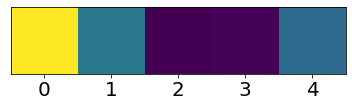

In [17]:
print (weights1)
plt.figure("weights1") # 图像窗口名称
plt.imshow(weights1.unsqueeze(0).cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/weights1.jpg', dpi=500)
plt.show()

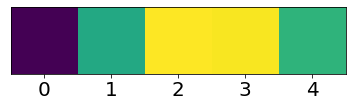

In [18]:
plt.figure("weights2") # 图像窗口名称
plt.imshow(weights2.unsqueeze(0).cpu())
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/weights2.jpg', dpi=500)
plt.show()

tensor([1.3193, 2.1180, 0.0436, 3.5569, 1.7595], device='cuda:0')


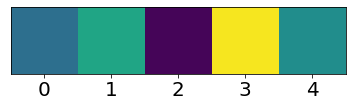

In [20]:
print (c_ij)
plt.figure("c_ij") # 图像窗口名称
plt.imshow(c_ij.unsqueeze(0).cpu(), vmin = 0, vmax = 3.6)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/c_ij.jpg', dpi=500)
plt.show()


tensor([0.1825, 0.2085, 0.1476, 0.2650, 0.1964], device='cuda:0')


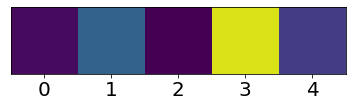

In [22]:
print (R)
plt.figure("R") # 图像窗口名称
plt.imshow(R.unsqueeze(0).cpu(), vmin = 0.18, vmax = 0.27)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/R.jpg', dpi=500)
plt.show()

tensor([[-5.1857e+00, -4.5698e+00, -6.1849e+00, -1.3192e+00,  1.0000e-05,
         -4.7813e+01, -4.9567e+00]], device='cuda:0')


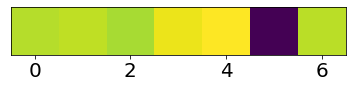

In [24]:
print (Coutputs1)
plt.figure("Coutputs1") # 图像窗口名称
plt.imshow(Coutputs1.cpu(), vmin = -48, vmax = 0.1)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/Coutputs1.jpg', dpi=500)
plt.show()

tensor([[86.6040,  2.4482, 84.9407, 88.4071, 90.5251, 84.6199, 85.7416]],
       device='cuda:0')


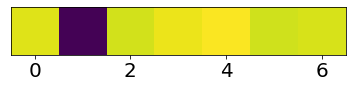

In [26]:
print (Coutputs2)
plt.figure("Coutputs2") # 图像窗口名称
plt.imshow(Coutputs2.cpu(), vmin = 2, vmax = 91)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/Coutputs2.jpg', dpi=500)
plt.show()

tensor([[ 94.8402, 146.1484, 145.9637, 149.9913, 150.0350, 145.6822, 100.6382]],
       device='cuda:0')


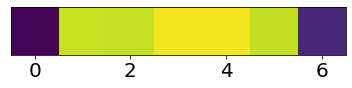

In [28]:
print (Coutputs3)
plt.figure("Coutputs3") # 图像窗口名称
plt.imshow(Coutputs3.cpu(), vmin = 94, vmax = 151)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/Coutputs3.jpg', dpi=500)
plt.show()

tensor([[142.4638, 143.1245,  78.9894, 145.2122, 148.7691, 142.0852, 142.6949]],
       device='cuda:0')


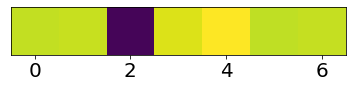

In [30]:
print (Coutputs4)
plt.figure("Coutputs4") # 图像窗口名称
plt.imshow(Coutputs4.cpu(), vmin = 78, vmax = 149)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/Coutputs4.jpg', dpi=500)
plt.show()

tensor([[79.6806, 71.7878, 75.9273, 95.5728, 97.3323, 81.1436, 81.0295]],
       device='cuda:0')


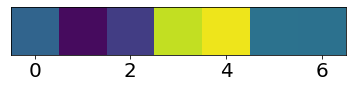

In [32]:
print (Cmimic)
plt.figure("Cmimic") # 图像窗口名称
plt.imshow(Cmimic.cpu(), vmin = 71, vmax = 98)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/Cmimic.jpg', dpi=500)
plt.show()

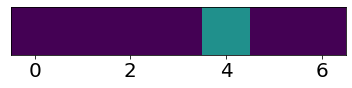

In [33]:
target = torch.nn.functional.one_hot(target, num_classes=7)
plt.figure("target") # 图像窗口名称
plt.imshow(target.cpu(), vmin = 0, vmax = 2)
plt.yticks([])
plt.tick_params(labelsize=20)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/target.jpg', dpi=500)
plt.show()